# Modules, colors, and functions

### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Extend the size of the Window

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load Modules

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import convolution as conv
from astropy.time import Time
import datetime
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pprint import pprint
import scipy as sp
from scipy.interpolate import griddata
from scipy import sparse, signal, stats
from scipy.stats import moment
import sunpy.cm as cm
import sunpy.map
import sunpy.physics.differential_rotation as dr

import torch
import torch.nn as nn
import torch.nn.functional as F

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

%matplotlib inline

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Load and interface with Google Cloud Storage

In [4]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
client = storage.Client()

### Remove Warnings and Define Color Defaults

You can switch colormaps between *hmimag* (*seismic*) if you want to focus on the *weak* (*strong*) magnetic features.

In [5]:
# Remove Warnings
# import warnings
# warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

## Read index file

In [6]:
path = '/mnt/mdi-hmi/to-ml-register-nodiff/train/'
index = pd.read_csv(path + 'index.csv')
index.head()

index                       filename_source  \
0      0   2010/4/7/MDI_20100407-013901_43.npy   
1      1  2010/4/7/MDI_20100407-013901_637.npy   
2      2  2010/4/7/MDI_20100407-013901_638.npy   
3      3  2010/4/7/MDI_20100407-013901_641.npy   
4      4  2010/4/7/MDI_20100407-013901_642.npy   

                        filename_target  patch_num                  dateobs  \
0   2010/4/7/HMI_20100407-013419_43.npy         43  2010-04-07 01:39:01.278   
1  2010/4/7/HMI_20100407-013419_637.npy        637  2010-04-07 01:39:01.278   
2  2010/4/7/HMI_20100407-013419_638.npy        638  2010-04-07 01:39:01.278   
3  2010/4/7/HMI_20100407-013419_641.npy        641  2010-04-07 01:39:01.278   
4  2010/4/7/HMI_20100407-013419_642.npy        642  2010-04-07 01:39:01.278   

   timedelta  
0   -282.278  
1   -282.278  
2   -282.278  
3   -282.278  
4   -282.278

## Define bins for histogram

In [7]:
# Logarithmic bins

dl=0.15  # Logarithmic width
lim = np.log10(5000) # Maximum value
noise_level = 0

# Creating positive part
bins = np.round(np.power(10,np.arange(1,lim+dl,dl)),2)

bins = bins-10+noise_level

# Mirroring it to 0
bins = np.append(np.flip(-(bins)), bins)

# Defining centers and bin widths for the learnable histogram
centers = (bins[1:]+bins[0:-1])/2
widths = (bins[1:]-bins[0:-1])

#print((bins).astype(int))
#print(centers)
#print(widths)

## Histogram for Batches

In [8]:
class HistLayer(nn.Module):

    def __init__(self,centers,widths):
        super(HistLayer, self).__init__()
        
        # Store centers and widths
        self.centers = centers
        self.widths = widths
        
        # Create array of non-zero centers to ignore noisy part of the spectrum
        nonzero = np.ones(centers.shape[0])
        nonzero[centers==0] = 0
        
        # Center calculation
        self.conv1 = nn.Conv2d(1, centers.shape[0], 1)        
        self.conv1.weight = torch.nn.Parameter(torch.from_numpy(nonzero[:,None,None,None]))
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(-centers*nonzero))
        
        # Width and offset calculation
        self.conv2 = nn.Conv2d(centers.shape[0], centers.shape[0], 1)
        
        # Setting weights and bias to zero for the center bin
        diag = -nonzero/widths
        
        self.conv2.weight = torch.nn.Parameter(torch.from_numpy(np.expand_dims(np.expand_dims(np.diag(diag),axis=2),axis=2)))

        self.conv2.bias = torch.nn.Parameter(torch.from_numpy(nonzero))
        
    def forward(self, x):
        patch_size = x.shape[2]

        if len(x.shape) == 3:
            x = x[:, None, :, :]
        else:
            x = x[:, 0, :, :]
            x = x[:, None]
        
        x = self.conv1(x)
        x = torch.abs(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.avg_pool2d(x,patch_size)*patch_size*patch_size
        
        return x

In [9]:
net = HistLayer(centers, widths)
net = net.float()
net

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


HistLayer(
  (conv1): Conv2d(1, 37, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(37, 37, kernel_size=(1, 1), stride=(1, 1))
)

# Test on Batches

In [10]:
randN = (np.random.rand(10)*index.shape[0]).astype(int)
for idx, val in enumerate(randN):
    if idx==0:
        data = np.load(path + index.loc[val,'filename_target'])
        data = data[None,None,0,:,:]
    else:
        tmp = np.load(path + index.loc[val,'filename_target'])
        tmp = tmp[None,None,0,:,:]
        data = np.append(data,tmp,axis=0)
    
dataP = torch.from_numpy(data)
dataP.shape

torch.Size([10, 1, 128, 128])

In [11]:
mdi_bucket = 'mdi-fits'
# mdi_file = 'mdi-data/mdi-prep/2011/4/1/MDI_20110401-031101.fits'
# New data test bucket
mdi_file = 'mdi-data/mdi-prep/2011/3/13/MDI_20110313-031501.fits'

bucket = client.get_bucket(mdi_bucket)
blob = bucket.blob(mdi_file)
file = blob.download_to_filename('/tmp/tmp_mdi.fits')

MDI_fits = fits.open('/tmp/tmp_mdi.fits', cache=False)
MDI_fits.verify('fix')

MDImap = sunpy.map.Map(MDI_fits[1].data, MDI_fits[1].header)
MDI_fits.close()

x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
hpc_coords = MDImap.pixel_to_world(x, y)
rSun = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImap.rsun_obs

# Mask data and rSun array to be on disk only
MDImap.data[rSun>1] = 0
rSun[rSun>1] = 0

# patchesMDI = get_patch(MDImap, 128, instrument='MDI', target_scale=0.504273, stride=128)

('obs_l0', 'obs_b0', 'obs_dist')
('hgln_obs', 'hglt_obs', 'dsun_obs')
('crln_obs', 'crlt_obs', 'dsun_obs') [sunpy.map.mapbase]


In [12]:
hmi_bucket = 'hmi-fits'
# hmi_file = 'hmi-data/hmi-prep/2011/4/1/HMI_20110401-014618.fits'
# New data test bucket
hmi_file = 'hmi-data/hmi-prep/2011/3/13/HMI_20110313-031015.fits'


bucket = client.get_bucket(hmi_bucket)
blob = bucket.blob(hmi_file)
file = blob.download_to_filename('/tmp/tmp_hmi.fits')

HMI_fits = fits.open('/tmp/tmp_hmi.fits', cache=False)
HMI_fits.verify('fix')

HMImap = sunpy.map.Map(HMI_fits[1].data, HMI_fits[1].header)
HMI_fits.close()

x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
hpc_coords = HMImap.pixel_to_world(x, y)
rSunH = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / HMImap.rsun_obs

# Mask data and rSun array to be on disk only
HMImap.data[rSunH>0.985] = 0

In [13]:
HMImap.data.shape
dataP = torch.from_numpy(HMImap.data[None, None, :])
dataP.shape

torch.Size([1, 1, 4096, 4096])

In [14]:
cnnhist = net(dataP.float())
cnnhist.shape

torch.Size([1, 37, 1, 1])

## Plot histograms in batch

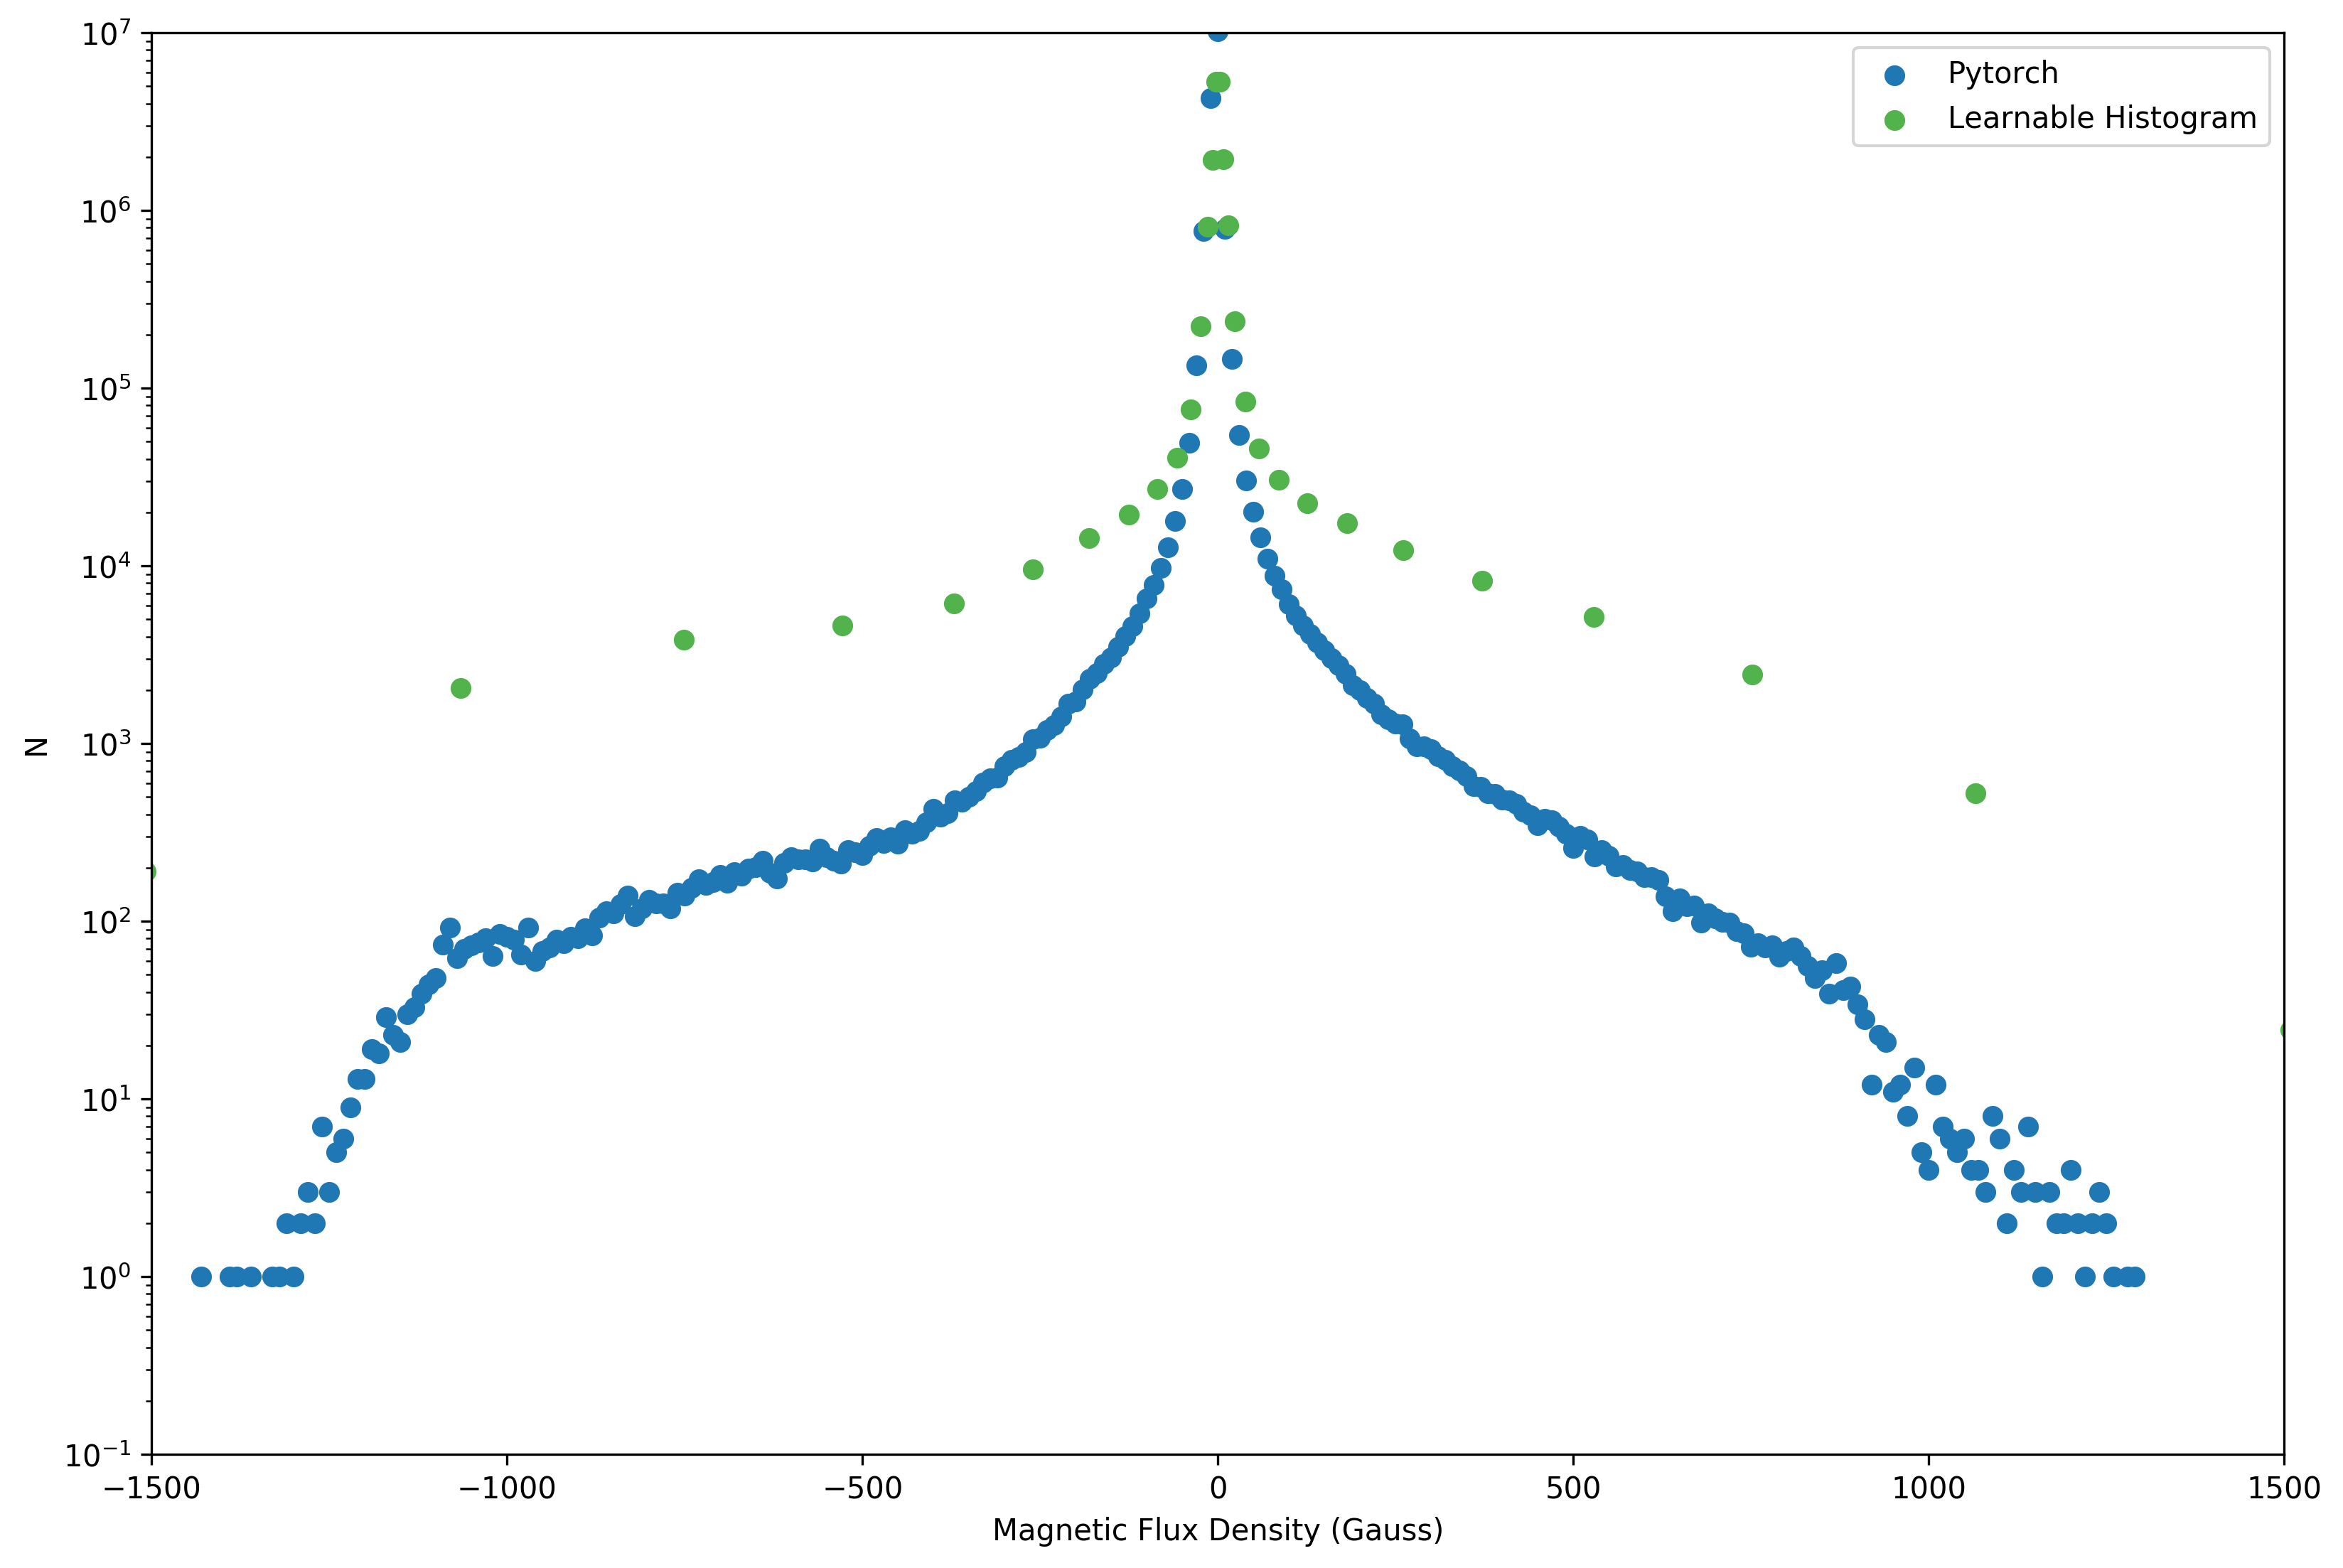

In [35]:
batch_index = 0

# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = 2000    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])


# Set noise level data to zero
dataN = dataP[batch_index, 0,:,:]
dataN[np.logical_and(dataN>-noise_level, dataN<noise_level)]=np.nan
#ax1.hist(dataN.reshape(-1),bins=bins, label='Numpy Histogram',color=Clr[5])

conv_img = dataP
P = torch.histc(dataN.cpu(), bins=300, min=-1500, max=1500)
x_p = np.arange(-1500, 1500,10)
ax1.scatter(x_p, P, label='Pytorch')

ax1.scatter(centers,np.squeeze(cnnhist.detach().numpy()[batch_index, :,0,0]), label='Learnable Histogram', color=Clr[3], zorder=2)

ax1.set_yscale('log')
#ax1.set_xscale('symlog')

ax1.set_xlim(-1500, 1500)
ax1.set_ylim(0.1, 10000000)

ax1.legend()

ax1.set_xlabel('Magnetic Flux Density (Gauss)')
ax1.set_ylabel('N');
